# Create 2D dataset using 3D volumes of BRATS 2018 DATASET 

In [174]:
from importlib.resources import path
import os 
import nibabel as nib
import numpy as np
import random
from PIL import Image

def extract_images_from_slices(frames_range, save_folder, seed = 0):
    root_dir = "C:/Users/Station5/Downloads/datasets/MICCAI_BraTS_2018_Data_Training/LGG"
    flair = list()
    t1 = list()
    t2 = list()
    mask = list()

    for dirpath in os.listdir(root_dir):
        if os.path.isdir(os.path.join(root_dir,dirpath)):
            for filename in os.listdir(os.path.join(root_dir,dirpath)):
                if filename.endswith('_flair.nii'): flair.append(os.path.join(os.path.join(root_dir,dirpath,filename))) 
                if filename.endswith('_t1ce.nii'): t1.append(os.path.join(os.path.join(root_dir,dirpath,filename))) 
                if filename.endswith('_t2.nii'): t2.append(os.path.join(os.path.join(root_dir,dirpath,filename))) 
                if filename.endswith('_seg.nii'): mask.append(os.path.join(os.path.join(root_dir,dirpath,filename)))
       
            
                 
    all_indices = set(np.arange(len(flair)))
    random.seed(seed)  #every time set the same seed
    test_ratio = 0.2
    test_indices = random.sample(all_indices, int(test_ratio*len(all_indices)))
    train_indices = np.setdiff1d(list(all_indices), test_indices)
    np.random.seed(seed)
    np.random.shuffle(train_indices)
    train_indices = sorted(train_indices)
    random.seed(seed)  #every time set the same seed
    val_ratio = 0.2 
    val_indices = random.sample(train_indices, int(val_ratio*len(train_indices)))
    train_indices = np.setdiff1d(list(train_indices), val_indices)

    save_frames(frames_range, save_folder,flair, t1, t2, mask, train_indices, split_type= "train")
    save_frames(frames_range, save_folder,flair, t1, t2, mask, test_indices, split_type= "test")
    save_frames(frames_range, save_folder,flair, t1, t2, mask, val_indices, split_type="val") 
    
def filter_frame(mask):
    cls, counts = np.unique(mask, return_counts=True)
    satisfy = False
    for cl, cn in zip(cls,counts):
        if (cl == 1) or (cl == 2) or (cl == 4):
            if cn > 1000:
                satisfy = True
    return satisfy

def save_frames(frames_range, save_folder, flair, t1, t2, mask, indices, split_type = "train"):
    all_images_flair = list()
    all_t1_flair = list()
    all_t2_flair = list()
    all_mask_flair = list()

    flair_list = [f for i, f in enumerate(flair) if i in indices]
    t1_list = [t1_ for i, t1_ in enumerate(t1) if i in indices]
    t2_list = [t2_ for i, t2_ in enumerate(t2) if i in indices]
    mask_list = [m for i, m in enumerate(mask) if i in indices]


    for indx in range(len(flair_list)):
        flair_img=nib.load(flair_list[indx]).get_fdata()
        t1_img=nib.load(t1_list[indx]).get_fdata()
        t2_img=nib.load(t2_list[indx]).get_fdata()
        mask_img=nib.load(mask_list[indx]).get_fdata()

        for frame in range(frames_range[0], frames_range[1]):

            mask_slice = mask_img[:,:,frame]

            if filter_frame(mask_slice):
                flair_slice = flair_img[:,:,frame]
                t1_slice = t1_img[:,:,frame]
                t2_slice = t2_img[:,:,frame]

                os.makedirs(os.path.join(save_folder,"train"), exist_ok= True)
                os.makedirs(os.path.join(save_folder,"test"), exist_ok= True)
                os.makedirs(os.path.join(save_folder,"val"), exist_ok= True)

                all_images_flair.append(flair_slice) 
                all_t1_flair.append(t1_slice) 
                all_t2_flair.append(t2_slice) 
                all_mask_flair.append(mask_slice) 
    

    all_images_flair = np.array(all_images_flair)
    all_t1_flair = np.array(all_t1_flair)
    all_t2_flair = np.array(all_t2_flair)
    all_mask_flair = np.array(all_mask_flair).astype(np.uint8)

    print (all_images_flair.shape)
    
    np.save(os.path.join(save_folder,split_type,"flair_seed0_LGG.npy"), arr= all_images_flair)
    np.save(os.path.join(save_folder,split_type,"t1_seed0_LGG.npy"), arr= all_t1_flair)
    np.save(os.path.join(save_folder,split_type,"t2_seed0_LGG.npy"), arr= all_t2_flair)
    np.save(os.path.join(save_folder,split_type,"mask_seed0_LGG.npy"), arr= all_mask_flair)



In [22]:
extract_images_from_slices(frames_range=(0,155), save_folder= "data/BraTS_frames/MIUA")

C:\Users\Station5\AppData\Local\Temp\ipykernel_10612\3800746495.py:28: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  test_indices = random.sample(all_indices, int(test_ratio*len(all_indices)))


(1561, 240, 240)
(572, 240, 240)
(257, 240, 240)


In [29]:
import numpy as np
train = np.load("data/BraTS_frames/MIUA/train/flair_seed0_HGG.npy")
val = np.load("data/BraTS_frames/MIUA/val/flair_seed0_HGG.npy")
test = np.load("data/BraTS_frames/MIUA/test/flair_seed0_HGG.npy")
print (train.shape,val.shape,test.shape)

(3673, 240, 240) (1009, 240, 240) (1164, 240, 240)


## Check loading the Brats dataset

In [2]:
import os
import numpy as np
from numpy import asarray, dtype
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision
from collections import namedtuple
import numpy
import PIL.Image as Image
import math
import random
import pdb
from torchvision.transforms import functional as F
from torchvision.transforms.functional import InterpolationMode, _interpolation_modes_from_int


class BraTSDataset(Dataset):


    def __init__(self, root_dir, split_dir="train/", flip=False, resize = None, scale= None, crop=None, version = 1, brightness = False, \
                  v_flip = False, rotation = False, random_crop = False, segmentation_type = "whole_tumor"):
        
        self.flip = flip
        self.scale = scale
        self.resize = resize
        self.crop = crop
        self.root_dir = root_dir
        self.rotation = rotation
        self.v_flip = v_flip
        self.brightness = brightness

        self.random_crop = random_crop
        self.split_dir = split_dir
        self.flair_dir = 'flair'
        self.t1_dir = 't1'
        self.mask_dir = 'mask'
        self.segmentation_type = segmentation_type
        
        

        if version == 5:
            self.flair_files = numpy.load(self.root_dir+split_dir+'flair_seed0_HGG.npy', allow_pickle='TRUE')
            self.t1_files = numpy.load(self.root_dir+split_dir+'t1_seed0_HGG.npy', allow_pickle='TRUE')
            self.mask_files = numpy.load(self.root_dir+split_dir+'mask_seed0_HGG.npy', allow_pickle='TRUE')

        elif version == 6:
            self.flair_files = numpy.load(self.root_dir+split_dir+'flair_seed0_LGG.npy', allow_pickle='TRUE')
            self.t1_files = numpy.load(self.root_dir+split_dir+'t1_seed0_LGG.npy', allow_pickle='TRUE')
            self.mask_files = numpy.load(self.root_dir+split_dir+'mask_seed0_LGG.npy', allow_pickle='TRUE')

        elif version == 7:

            self.flair_files = numpy.load(self.root_dir+split_dir+'flair_seed0_HGG.npy', allow_pickle='TRUE')
            self.t1_files = numpy.load(self.root_dir+split_dir+'t1_seed0_HGG.npy', allow_pickle='TRUE')
            self.mask_files = numpy.load(self.root_dir+split_dir+'mask_seed0_HGG.npy', allow_pickle='TRUE')

            ### concat HGG and LGG
            self.flair_files = np.concatenate((self.flair_files,numpy.load(self.root_dir+split_dir+'flair_seed0_LGG.npy', allow_pickle='TRUE')))
            self.t1_files = np.concatenate((self.t1_files,numpy.load(self.root_dir+split_dir+'t1_seed0_LGG.npy', allow_pickle='TRUE')))
            self.mask_files = np.concatenate((self.mask_files,numpy.load(self.root_dir+split_dir+'mask_seed0_LGG.npy', allow_pickle='TRUE')))
            
            
    def __len__(self):
        return len(self.flair_files)
    
    def slice_normalize(self,slice):
        '''
            input: unnormalized slice 
            OUTPUT: normalized clipped slice
        '''

        # make sure that percentile below 1% and above 99% are cutoff
        b = np.percentile(slice, 99)
        t = np.percentile(slice, 1)
        slice = np.clip(slice, t, b)

        return slice
        
    def __getitem__(self, idx):

        flair_image = self.flair_files[idx]
        t1_image = self.t1_files[idx]

        
        flair_image = self.slice_normalize(flair_image)
        t1_image = self.slice_normalize(t1_image)
        
        flair_image = (torch.tensor(flair_image, dtype = torch.float32)).unsqueeze(0)
        t1_image = (torch.tensor(t1_image, dtype = torch.float32)).unsqueeze(0)
        mask = (torch.tensor(self.mask_files[idx])).unsqueeze(0)

        # ### make sure you dont go out of index, there is no class 3. so we are replacing 4 with 3
        # mask[mask==4] = 2
        # mask[mask == 2] = 2

        if self.segmentation_type == "whole_tumor":
            ### make sure that we have only one class
            # replace 3 with 1
            mask[mask==4] = 1
            mask[mask == 2] = 1

        if self.segmentation_type == "core_tumor":
            ### make sure that we have only one class
            mask[mask==4] = 1
            mask[mask==2] = 0

        if self.segmentation_type == "ET":
            ### make sure that we have only one class
            mask[mask==1] = 0
            mask[mask==2] = 0
            mask[mask==4] = 1
       
    
        flair_image, mask, t1_image = preprocess(flair_image, mask, t1_image, flip= self.flip, resize= self.resize, crop= self.crop, rotation = self.rotation, v_flip =self.v_flip, brightness = self.brightness, random_crop= self.random_crop)

        # flair_image = (flair_image/flair_image.max())
        # t1_image =  (t1_image/t1_image.max())
        
        flair_image = (flair_image - flair_image.min())/(flair_image.max() - flair_image.min())
        t1_image =  (t1_image - t1_image.min())/(t1_image.max()-t1_image.min())

        

        # # normalize the image to 0 mean and 1 std
        # flair_image = (flair_image - 0.110038705)/0.20635846
        # t1_image = (t1_image - 0.0982156)/0.17687258

        #broast cast all images to 3 channel
        # flair_image = flair_image.repeat(3,1,1)
        # t1_image = t1_image.repeat(3,1,1)
        
        return flair_image, mask.squeeze(0), t1_image
    

def preprocess(flair, mask, t1,  flip=False, resize = None, crop=None, rotation = False, v_flip = False, brightness = False, random_crop = False):


    if crop:
        flair = F.center_crop(flair,crop)
        t1 = F.center_crop(t1,crop)
        mask = F.center_crop(mask,crop)


    if resize:
        previous = len(np.unique(mask))
        flair = F.resize(flair, size= resize, interpolation =InterpolationMode.BILINEAR, antialias = True)
        t1 = F.resize(t1, size= resize, interpolation =InterpolationMode.BILINEAR, antialias = True)
        mask = F.resize(mask, size= resize, interpolation =InterpolationMode.NEAREST, antialias = False)
        # if len(np.unique(mask)) != previous:
        #     print ("The classes has been changed due to downsampling")


    if random_crop:
        
        _,h,w = mask.shape
        
        if random.random() < 0.5:
            new_size = random.uniform(h-40,h-10)
            flair = F.center_crop(flair,new_size)
            t1 = F.center_crop(t1,new_size)
            mask = F.center_crop(mask,new_size)

        # make sure to resize back to the original size
        flair = F.resize(flair, size= (h,w), interpolation =InterpolationMode.BILINEAR, antialias = True)
        t1 = F.resize(t1, size= (h,w), interpolation =InterpolationMode.BILINEAR, antialias = True)
        mask = F.resize(mask, size= (h,w), interpolation =InterpolationMode.NEAREST, antialias = False)
        


    if flip:
        if random.random() < 0.5:
            flair = F.hflip(flair)
            t1 = F.hflip(t1)
            mask =F.hflip(mask)

    if v_flip:
        if random.random() < 0.5:
            flair = F.vflip(flair)
            t1 = F.vflip(t1)
            mask =F.vflip(mask)

    if rotation:
        if random.random() < 0.5:
            degree = random.uniform(-20,20)
            flair = F.rotate(flair, degree, interpolation = InterpolationMode.BILINEAR, fill = 0.)
            t1 = F.rotate(t1, degree, interpolation = InterpolationMode.BILINEAR, fill = 0.)
            mask = F.rotate(mask, degree, interpolation = InterpolationMode.NEAREST, fill = 0.)

    # if brightness:
    #     brightness_factor = random.uniform(0.9,1.1)
    #     flair = F.adjust_brightness(flair, brightness_factor)
    #     t1 = F.adjust_brightness(t1, brightness_factor)

    # if shear:
    #     if random.random() < 0.5:
    #         shear_degree = random.uniform(-10,10)
    #         flair = F.affine(flair, angle =0, translate = (0,0), interpolation = InterpolationMode.BILINEAR)
    #         t1 = F.affine(t1, degree, interpolation = InterpolationMode.BILINEAR)
    #         mask = F.affine(mask, degree, interpolation = InterpolationMode.NEAREST)

    mask = mask.long()
    return flair, mask, t1


c:\Users\Station5\miniconda3\envs\dplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## COMPUTE DATASET STATISTICS

In [3]:
dataset = BraTSDataset("data/BraTS_frames/MIUA/", flip = False, split_dir ="train/", resize= 0, \
                           crop = 0, version= 5,v_flip = False, brightness = False, rotation = False, random_crop= False)
def compute_mean(data):
    
    mean = np.mean(data) 
    std = np.std(data) 

    print ("mean: ", mean, "std :",std, "max: ",np.max(data), "min: ", np.min(data))

t1s = []
flairs = []

for i, (flair, m, t1) in enumerate(dataset):
    flairs.append(flair.numpy())
    t1s.append(t1.numpy())
   
    
t1s = np.array(t1s)
flairs = np.array(flairs)

compute_mean(flairs)
compute_mean(t1s)

mean:  0.14407136 std : 0.26404217 max:  1.0 min:  0.0
mean:  0.18798836 std : 0.3249902 max:  1.0 min:  0.0


### HGG Statistics 
##### mean:  0.14407136 std : 0.26404217 max:  1.0 min:  0.0
##### mean:  0.18798836 std : 0.3249902 max:  1.0 min:  0.0

### HISTOGRAM PLOT

{2: 154, 3: 57, 4: 798}


Text(0.5, 0, 'Classes')

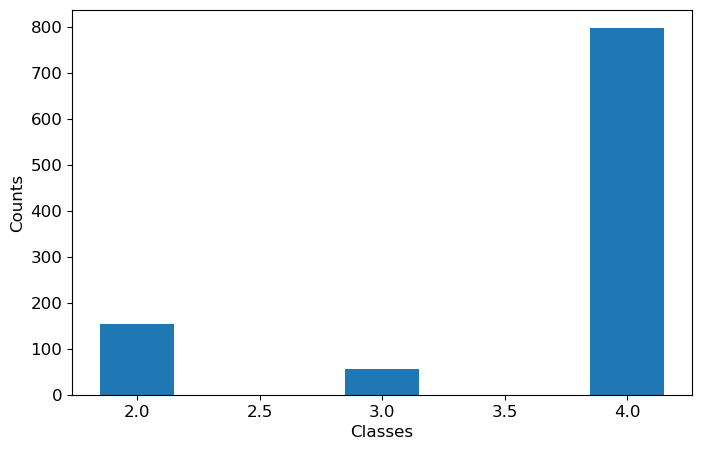

In [4]:
data = numpy.load("data/BraTS_frames/MIUA/val/"+'mask_seed0_HGG.npy', allow_pickle='TRUE')
classes = {2:0,3:0,4:0}
for d in data:
    no_classes = len(numpy.unique(d))
    classes[no_classes] = classes[no_classes]+1
    
print (classes)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size':12})
plt.figure(figsize=(8,5))
plt.bar(classes.keys(),classes.values(), width = 0.3)
plt.ylabel("Counts")
plt.xlabel("Classes")

### PIXEL HISTOGRAMS

<class 'numpy.ndarray'>


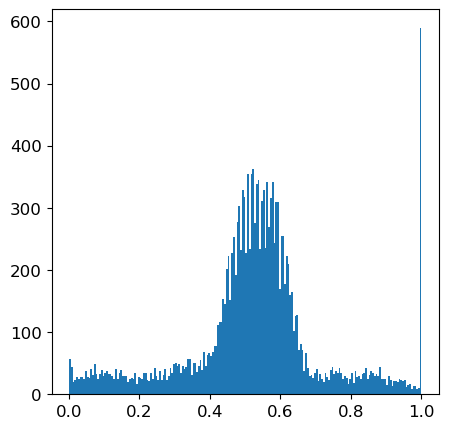

In [5]:
flairs = []
classes = []
t1s = []
masks = []

train_dataset = BraTSDataset("data/BraTS_frames/MIUA/", flip = True, split_dir ="train/", resize= 0, \
                             crop = 0, version= 5,v_flip = True, brightness = True, rotation = True, random_crop= True)
for i, (flair, m, t1) in enumerate(train_dataset):
    flairs.append(flair)
    t1s.append(t1)
    masks.append(m)
   
f1 = np.array(flairs[0]).flatten()
for f in flairs:
    np.concatenate((f1, np.array(f).flatten()))

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
print (type(f1))
plt.hist(f1[f1 !=0.], bins = 200)

plt.show()

# VISUALIZE IMAGES AND MASKS

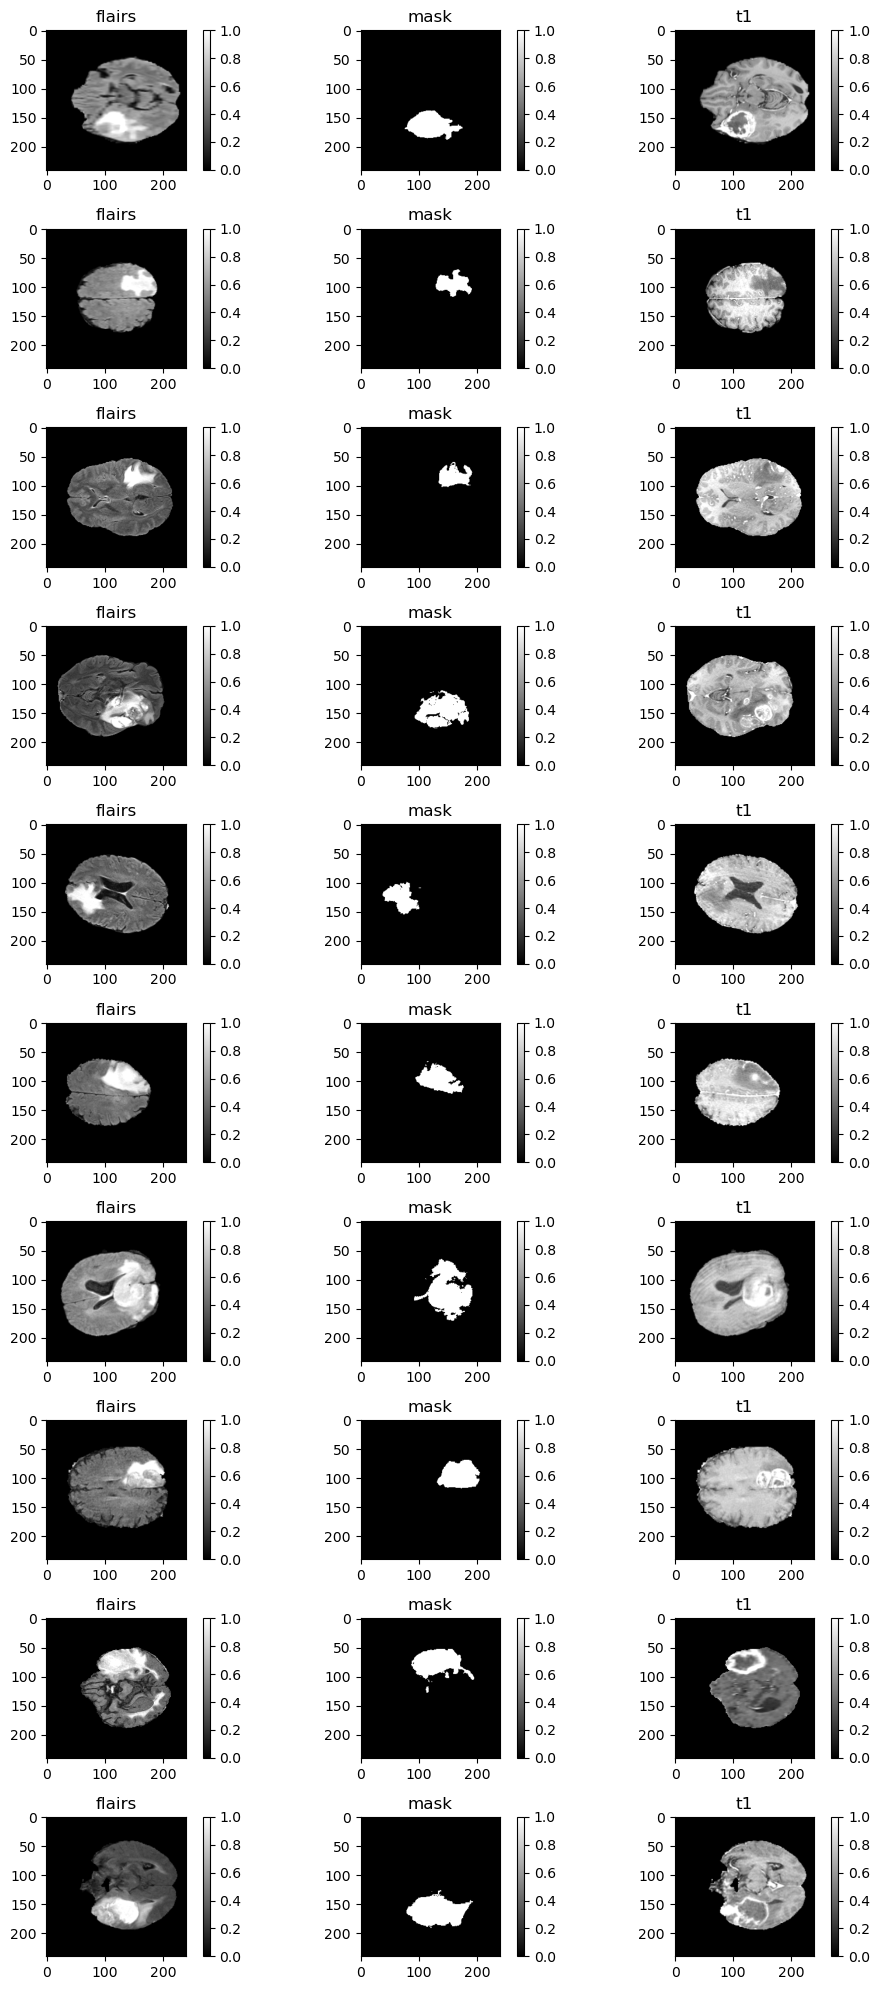

In [167]:

import matplotlib.pyplot as plt
# visualize the images 
f, axarr = plt.subplots(10,3, figsize = (10,20))
cnt = 0
for i in range(0,3000,300):
   
    adjust_i = cnt
    cnt+=1

    d1  =axarr[adjust_i,0].imshow(flairs[i].squeeze(0), cmap = "gray")
    axarr[adjust_i,0].set_title("flairs")
    plt.colorbar(d1, ax=axarr[adjust_i, 0])

    d2 = axarr[adjust_i,1].imshow(masks[i], cmap = "gray")
    axarr[adjust_i,1].set_title("mask")
    plt.colorbar(d2, ax=axarr[adjust_i, 1])
    
    d3 = axarr[adjust_i,2].imshow(t1s[i].squeeze(0), cmap = "gray")
    axarr[adjust_i,2].set_title("t1")
    plt.colorbar(d3, ax=axarr[adjust_i, 2])

    plt.tight_layout()


## Save the classification multi-labels

In [42]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy

def classification_labels(mask, classes = [1,2,4]):
        one_hot_labels = torch.zeros(len(classes),dtype = torch.double)
       
        for i, k in enumerate(classes):
            if k in mask:
                one_hot_labels[int(i)]= 1
        return one_hot_labels

def BraTSDataset_save_classification(root_dir, split_dir="train/",version = 1):
        
    root_dir = root_dir
    split_dir = split_dir
    classes = []

    if version == 5:
        mask_files = numpy.load(root_dir+split_dir+'mask_seed0_HGG.npy', allow_pickle='TRUE')

    elif version == 6:
        mask_files = numpy.load(root_dir+split_dir+'mask_seed0_LGG.npy', allow_pickle='TRUE')

    for mask in mask_files:
        classes.append(classification_labels(mask))

    classes = np.array(classes) 

    if version == 5:
        np.save(os.path.join(root_dir,split_dir,"multilabel_classes_seed0_HGG.npy"), arr= classes)
    elif version == 6: 
        np.save(os.path.join(root_dir,split_dir,"multilabel_classes_seed0_LGG.npy"), arr= classes)
    
        

In [43]:
BraTSDataset_save_classification("data/BraTS_frames/MIUA/", split_dir ="train/", version= 5)
BraTSDataset_save_classification("data/BraTS_frames/MIUA/", split_dir ="test/", version= 5)
BraTSDataset_save_classification("data/BraTS_frames/MIUA/", split_dir ="val/", version= 5)
BraTSDataset_save_classification("data/BraTS_frames/MIUA/", split_dir ="train/", version= 6)
BraTSDataset_save_classification("data/BraTS_frames/MIUA/", split_dir ="test/", version= 6)
BraTSDataset_save_classification("data/BraTS_frames/MIUA/", split_dir ="val/", version= 6)

C:\Users\Station5\AppData\Local\Temp\ipykernel_10612\1385756128.py:39: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  classes = np.array(classes)
C:\Users\Station5\AppData\Local\Temp\ipykernel_10612\1385756128.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  classes = np.array(classes)


In [46]:
data = np.load('data/BraTS_frames/MIUA/test/multilabel_classes_seed0_HGG.npy', allow_pickle = True)

## Load classification

In [53]:
from logging import raiseExceptions
import os
import numpy as np
from numpy import asarray, dtype
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision
from collections import namedtuple
import numpy
import PIL.Image as Image
from utils import *
import math
import random
import pdb
from torchvision.transforms import functional as F
from torchvision.transforms.functional import InterpolationMode, _interpolation_modes_from_int

class BraTSDataset(Dataset):


    def __init__(self, root_dir, train = True, flip=False, resize = None, scale= None, crop=None):
        
        self.flip = flip
        self.scale = scale
        self.resize = resize
        self.crop = crop
        self.root_dir = root_dir

        if train:
            split_dir = "train"
        else:
            split_dir = "test"
            
        self.flair_files = numpy.load(os.path.join(self.root_dir,split_dir,'flair_multilabel.npy'), allow_pickle='TRUE')
        self.t1_files = numpy.load(os.path.join(self.root_dir,split_dir,'t1_multilabel.npy'), allow_pickle='TRUE')
        self.class_files = numpy.load(os.path.join(self.root_dir,split_dir,'classes_multilabel.npy'), allow_pickle='TRUE')
        self.mask_files = numpy.load(os.path.join(self.root_dir,split_dir,'mask_multilabel.npy'), allow_pickle='TRUE')


        
    def __len__(self):
        return len(self.flair_files)
    
    def __getitem__(self, idx):
        
        flair_image = (torch.tensor(self.flair_files[idx], dtype = torch.float32))
        t1_image = (torch.tensor(self.t1_files[idx], dtype = torch.float32))
        classes = (torch.tensor(self.class_files[idx]))
        mask = (torch.tensor(self.mask_files[idx])).unsqueeze(0)

        # print(np.unique(mask),classes)
       
        
        flair_image, mask, t1_image = preprocess(flair_image, mask, t1_image, flip= self.flip, resize= self.resize, crop= self.crop)
        # print (flair_image.shape)

        return flair_image/2000, classes, t1_image/2000, mask
       

def preprocess(flair, mask, t1,  flip=False, resize = None, crop=None):


    if resize:
        previous = len(np.unique(mask))
        flair = F.resize(flair, size= resize, interpolation =InterpolationMode.BILINEAR, antialias = True)
        t1 = F.resize(t1, size= resize, interpolation =InterpolationMode.BILINEAR, antialias = True)
        mask = F.resize(mask, size= resize, interpolation =InterpolationMode.NEAREST, antialias = False)
        if len(np.unique(mask)) != previous:
            print ("The classes has been changed due to downsampling")
            # raise NotImplementedError

    if crop:
        flair = F.center_crop(flair,crop)
        t1 = F.center_crop(t1,crop)
        mask = F.center_crop(mask,crop)


    if flip:
        if random.random() < 0.5:
            flair = F.hflipe(flair)
            t1 = F.hflip(t1)
            mask =F.hflip(mask)

    mask = mask.long()
    
    return flair, mask, t1
   

tensor([1., 1., 1.], dtype=torch.float64)
